In [18]:
# Mount Drive, Data is saved on my google drive account
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import pickle
import os
import ipaddress
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

# Initialize some colors
R = "\033[91m"  # Red text
W = "\033[0m"   # Reset to default
G = "\033[92m"  # Green text

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
PROJECT_ROOT = '/content/drive/MyDrive/IDS'
PATH = os.path.join(PROJECT_ROOT, "pkl")
DATA_PATH = os.path.join(PROJECT_ROOT, f'{PATH}/p_data.pkl')
MODEL_PATH = os.path.join(PROJECT_ROOT, f'{PROJECT_ROOT}/model.keras')
print(DATA_PATH)

/content/drive/MyDrive/IDS/pkl/p_data.pkl


In [20]:
# Load Data
try:
  data = pd.read_pickle(DATA_PATH)
  print(f'{G} Data Loaded! {W}')
except:
  print(f'{R} Data Not Found! {W}')
data.info()

 Data Loaded! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589530 entries, 0 to 589529
Data columns (total 53 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   uid                              589530 non-null  int64  
 1   src_ip                           589530 non-null  uint64 
 2   src_p                            589530 non-null  int64  
 3   dst_ip                           589530 non-null  uint64 
 4   dst_p                            589530 non-null  int64  
 5   duration                         589530 non-null  float64
 6   missed_bytes                     589530 non-null  int64  
 7   history                          589530 non-null  int64  
 8   ip_proto                         589530 non-null  int64  
 9   src_bytes/src_pkts               589530 non-null  float64
 10  dst_bytes/dst_pkts               589530 non-null  float64
 11  proto_tcp                        589530 non-null  

In [21]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

original_indices = data.index.tolist()
X_train, X_test, train_indices, test_indices = train_test_split( features_scaled, original_indices, test_size=0.2, random_state=42 )


# Build the Sequential Autoencoder Model
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True, mode='min')
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')
])
model.compile(
    optimizer=optimizer,
    loss='mse'
)

history = model.fit(X_train, X_train, epochs=100, batch_size=512, validation_data=(X_test, X_test), shuffle=True, callbacks=early_callback )

reconstructions = model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.0306 - val_loss: 0.9302
Epoch 2/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.9051 - val_loss: 0.8210
Epoch 3/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7035 - val_loss: 0.7367
Epoch 4/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7298 - val_loss: 0.6643
Epoch 5/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6141 - val_loss: 0.6139
Epoch 6/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5537 - val_loss: 0.5791
Epoch 7/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.5717 - val_loss: 0.5521
Epoch 8/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.4691 - val_loss: 0.5302
Epoch 9/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4464 - val_loss: 0.5127
Epoch 10/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5073 - val_loss: 0.4983
Epoch 11/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4841 - val_loss: 0.4850
Epoch 12/100
922/922 ━━━━━━━━━━━━━━━━━

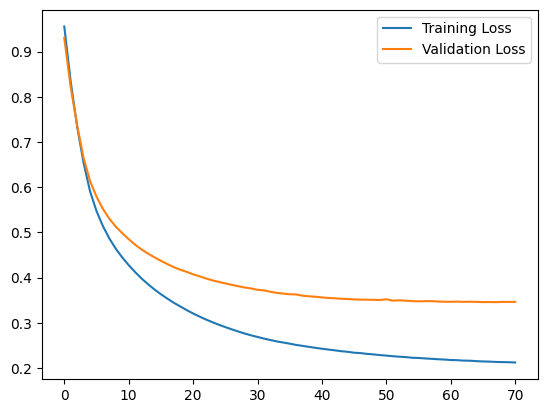

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

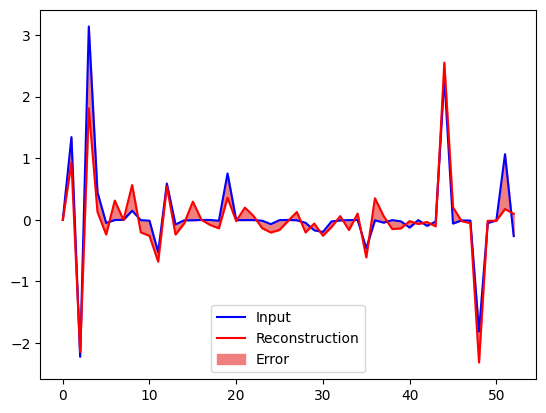

In [23]:
# Use the full autoencoder model

plt.plot(X_test[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(len(X_test[0])), reconstructions[0], X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

14739/14739 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step


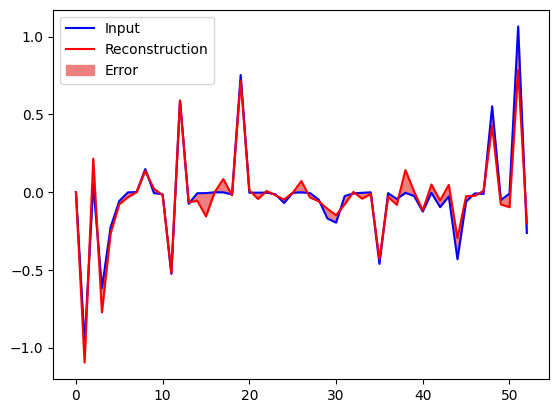

In [28]:
# Use the full autoencoder model
reconstructions2 = model.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions2, X_train)

plt.plot(X_train[0], 'b')
plt.plot(reconstructions2[0], 'r')
plt.fill_between(np.arange(len(X_train[0])), reconstructions2[0], X_train[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

14739/14739 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step


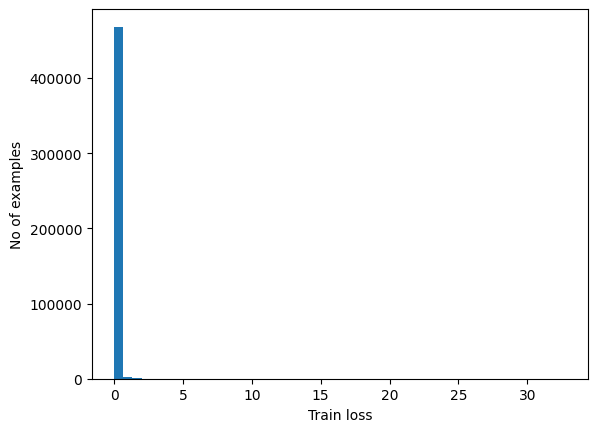

In [25]:
reconstructions2 = model.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions2, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

3685/3685 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


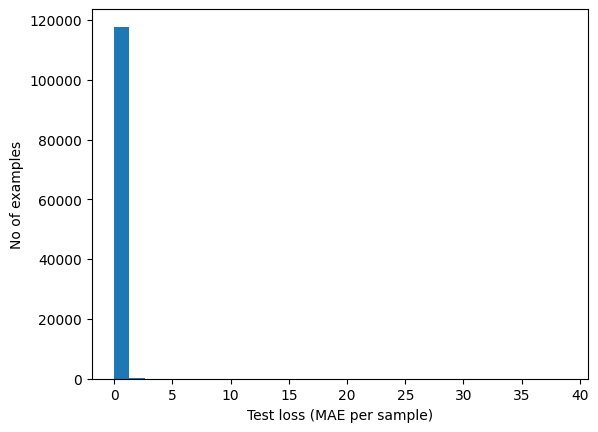

In [34]:
reconstructions3 = model.predict(X_test)
# Calculate reconstruction error per sample
train_loss = np.mean(np.abs(reconstructions3 - X_test), axis=1)
plt.hist(train_loss, bins=30)
plt.xlabel("Test loss (MAE per sample)")
plt.ylabel("No of examples")
plt.show()